

> # ***Review_Rating prediction with crawling live data from Amazon***

Using:
*   Gaussian Naive Bayes
*   K-Nearest Neighbour
*   Random Forest
*   Support Vector Machine (Linear SVC)
*   LSTM with PyTorch

Written by:
Amir Bahador Eizadkhah / eizadkhah.bit@gmail.com
Amin Nazarian Saralang / aminnazarian1987@gmail.com








## **Importing Libraries**

In [1]:
pip install langdetect

     |████████████████████████████████| 981 kB 14.0 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=f219d615d59362cb7e431467d6cf463af98d5c6b08429c5c7c065c2c2c4982a5
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [2]:
pip install translators --upgrade

     |████████████████████████████████| 6.4 MB 18.8 MB/s 
     |████████████████████████████████| 81 kB 11.8 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |████████████████████████████████| 65 kB 1.8 MB/s 
  Created wheel for PyExecJS: filename=PyExecJS-1.5.1-py3-none-any.whl size=14598 sha256=86387b4fe26ad12ea238a839dfbc9ceb9d93dfa63c51e979f05e449ae8622fc8
  Stored in directory: /root/.cache/pip/wheels/9a/ee/03/da5c0b4a8c13362beeb844eb913bbe58a89bde1de2b9157007
Successfully built PyExecJS
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [3]:
pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [1]:
import requests
import re
import string
import time
import random
import translators as ts
from langdetect import detect
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import seaborn as sns
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from wordcloud import WordCloud

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torchtext
from torch.nn import CrossEntropyLoss

from google.colab import drive

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

Using Netherlands server backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True


*   Mounting Google Drive and directory specifications


In [2]:
drive.mount('/content/drive')
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/PyCode/Dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def plot_proporsion(dataset, label):
    plt.figure(figsize=(6,6))
    plt.title('Percentage of category')
    ax = sns.countplot(y = label, data = dataset)
    total = len(dataset)
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width() / total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))

def plot_word_cloud(dataset, label):
    allw = ''
    for word in dataset[label]:
        allw += word

    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color ='white',
                          min_font_size = 10).generate(allw)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

## **Importing Dataset**

In [4]:
df = pd.read_csv(dataset_dir + 'Reviews.csv')
ds = df[['TEXT', 'SCORE']].copy()

ds.columns = ['TEXT', 'SCORE']
ds.to_csv(dataset_dir + 'Reviews_Modified.csv', index =None)

In [5]:
ds = pd.read_csv(dataset_dir + 'Reviews_Modified.csv')
ds = ds.dropna()

print('Dataset shape:', np.shape(ds))
print('Maximum rating scale of overall rating {}'.format(ds.SCORE.max()))
print('Minimum rating scale of overall rating {}'.format(ds.SCORE.min()))
print('Class Labels:', set(sorted(ds.SCORE)))

ds.head()

Dataset shape: (568454, 2)
Maximum rating scale of overall rating 5
Minimum rating scale of overall rating 1
Class Labels: {1, 2, 3, 4, 5}


,TEXT,SCORE
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


## **Creawing**

In [6]:
# Getting comments and reviews regarding the specific product

# https://www.amazon.co.uk/product-reviews/B07HN58Y53/ref=cm_cr_arp_d_paging_btm_next_1?ie=UTF8&reviewerType=all_reviews&pageNumber=0
# Cat Food

HEADERS = ({'User-Agent':
                'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
                AppleWebKit/537.36 (KHTML, like Gecko) \
                Chrome/100.0.4896.75 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'})


def getReviews(session, link):
    response = session.get(link, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'lxml')
    return soup.find_all('span', {'data-hook': 'review-body'})


def getRate(session, link):
    response = session.get(link, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'lxml')
    return soup.find_all('i', {'data-hook': 'review-star-rating'})

In [7]:
start_time = time.time()

X_tst = []
y_tst = []

FLAG = True
checking = 'https://www.amazon.'
while FLAG:
    link = input('Please put your Amazon link here: ')
    if checking in link:
        FLAG = False
    else:
        print('Your website either is not Amazon or has not observed "HTTPS" legislation.')
with requests.Session() as session:
    for i in range(400):
        for rates in getRate(session, link + str(i)):
            y_tst.append(f'{rates.text}\n'[0:3])
        for reviews in getReviews(session, link + str(i)):
            X_tst.append(f'{reviews.text}\n\n'[4:])

X_tst = np.asarray(X_tst)
y_tst = np.float64(np.asarray(y_tst))

data = {'TEXT': X_tst, 'SCORE': y_tst}

test_set = pd.DataFrame.dropna(pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()])))
print(test_set)
print(f'Total text cleaning time: {(time.time() - start_time)/60:.2f} min')

Please put your Amazon link here: https://www.amazon.co.uk/product-reviews/B07HN58Y53/ref=cm_cr_arp_d_paging_btm_next_1?ie=UTF8&reviewerType=all_reviews&pageNumber=0
                                                   TEXT  SCORE
0     let me start with the negative people with neg...    5.0
1     ortunately our cat won't so much as lick this ...    2.0
2     cat isn’t fussy, she once ate some rancid praw...    1.0
3     sked my cats why they would not  eat it,if loo...    1.0
4     ave an older cat (17+) who has gotten very pic...    4.0
...                                                 ...    ...
2363  sked my cats why they would not  eat it,if loo...    5.0
2364  ave an older cat (17+) who has gotten very pic...    3.0
2365  ently we have had to watch our spending a bit ...    4.0
2366  eally wanted my twin cats to like these. But t...    1.0
2367  ought this because despite the harsh reviews t...    2.0

[2368 rows x 2 columns]
Total text cleaning time: 3.62 min


### Proportion division

In [8]:
train_sample = np.round((len(test_set) * 0.8) / 0.2)
dataset = ds.sample(frac=1).reset_index(drop=True)
dataset = dataset.iloc[:int(train_sample)]
print('Dataset shape before crawling from Amazon:', np.shape(dataset))
dataset = dataset.append(test_set, ignore_index=True)
print('Dataset shape after crawling from Amazon:', np.shape(dataset))

plot_proporsion(dataset, ['score'])

Dataset shape before crawling from Amazon: (9472, 2)
Dataset shape after crawling from Amazon: (11840, 2)


## **Data preprocessing**

### Data Cleaning

In [9]:
def clean(text):
    
    # converting the all the text into lowercase
    text = str(text).lower()
    
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    if detect(text=text) != 'en':
        if len(text.split()) < 750:
            text = ts.google(text , to_language = 'en')
            text = re.sub('\[.*?\]', '', text)
            text = re.sub('https?://\S+|www\.\S+', '', text)
            text = re.sub('<.*?>+', '', text)
            text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
            text = re.sub('\n', '', text)
            text = re.sub('\w*\d\w*', '', text)
        else:
            text = 'Perfect, I love it.'
    else:
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('https?://\S+|www\.\S+', '', text)
        text = re.sub('<.*?>+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text)
        text = re.sub('\w*\d\w*', '', text)

    return text

In [10]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
start_time = time.time()

dataset['TEXT'] = dataset.TEXT.apply(lambda x: clean(x))
dataset['TEXT'] = dataset.TEXT.apply(
    lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))
dataset['TEXT'] = dataset.TEXT.apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
dataset['TEXT']= dataset.TEXT.apply(
    lambda x: ' '.join([ps.stem(word) for word in x.split()]))

dataset.columns = ['TEXT', 'SCORE']
dataset.to_csv(dataset_dir + 'Reviews_Modified.csv', index=None)
print(f'Total text cleaning time: {(time.time() - start_time)/60:.2f} min')

Total text cleaning time: 10.47 min


In [11]:
print(np.shape(dataset))
dataset.head()

(11840, 2)


,TEXT,SCORE
0,cooki essenti tasteless eat one consist weird ...,2.0
1,love tea good immun system help acheiv clear c...,5.0
2,famili adopt raw food diet last year one thing...,5.0
3,give tri wont want go back store brand fresh s...,5.0
4,twist fruit bill healthier altern snack target...,4.0


### Number to category

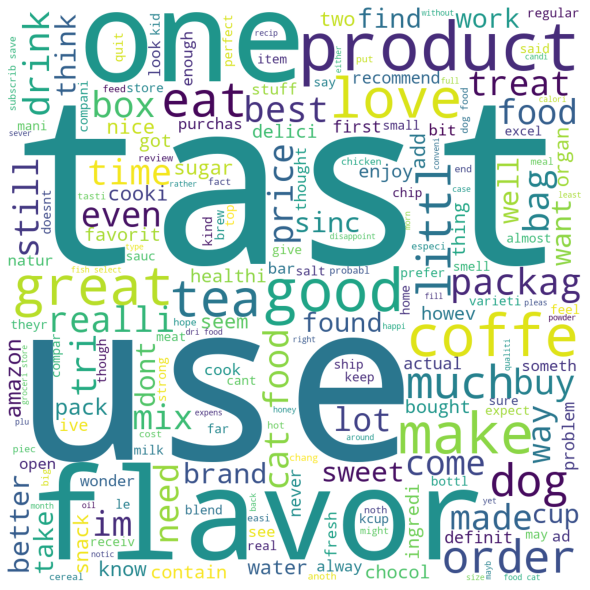

In [12]:
plot_word_cloud(dataset, 'TEXT')

### Vectorizing of dataset

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), lowercase=True, norm='l2', analyzer='word')
X_vec = tfidf_vectorizer.fit_transform(dataset['TEXT'].values)
y_vec = dataset['SCORE']

X, y = SMOTE().fit_resample(X_vec, y_vec)

print('Shape of the feature matrix:', np.shape(X))

Shape of the feature matrix: (33825, 5000)


### Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True)
print('Train Size:', np.shape(X_train))
print('Test Size:', np.shape(X_test))

Train Size: (27060, 5000)
Test Size: (6765, 5000)


> ## ***Classification with SK-Learn***

### **Classification**

#### Implementing Support Vector Machine

In [88]:
svm_classifier = LinearSVC(C=200, loss='hinge', dual=False, max_iter=10000, penalty='l2', random_state=0, multi_class='ovr')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

#### Implementing Random Forest

In [16]:
random_forest_classifier = RandomForestClassifier(n_estimators=300, random_state=0, criterion='gini', max_features='sqrt', warm_start=True)
random_forest_classifier.fit(X_train, y_train)
y_pred_rf = random_forest_classifier.predict(X_test)

#### Implementing K-Nearest Neighbour

In [146]:
knn_classifier = KNeighborsClassifier(n_neighbors=2, metric='minkowski', p=2, weights='distance')
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

#### Implementing Gaussian Naïve Bayes

In [103]:
nb_classifier = GaussianNB(var_smoothing=1e-3)
nb_classifier.fit(X_train.toarray(), y_train)
y_pred_nb = nb_classifier.predict(X_test.toarray())

### **Classification Report**

In [147]:
print('______________________ /Gaussian Naïve Bayes\ _______________________\n')
print('CLASSIFICATION REPORTS:\n')
print(classification_report(y_test, y_pred_nb, zero_division=0))
print('\nCONFUSION MATRIX:\n')
print(confusion_matrix(y_test, y_pred_nb))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_test, y_pred_nb) :.3f}')
print('____________________________________________________________________\n')

print('______________________ /K-Nearest Neighbour\ _______________________\n')
print('CLASSIFICATION REPORTS:\n')
print(classification_report(y_test, y_pred_knn, zero_division=0))
print('\nCONFUSION MATRIX:\n')
print(confusion_matrix(y_test, y_pred_knn))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_test, y_pred_knn) :.3f}')
print('____________________________________________________________________\n')

print('______________________ /Random Forest\ _______________________\n')
print('CLASSIFICATION REPORTS:\n')
print(classification_report(y_test, y_pred_rf, zero_division=0))
print('\nCONFUSION MATRIX:\n')
print(confusion_matrix(y_test, y_pred_rf))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_test, y_pred_rf) :.3f}')
print('____________________________________________________________________\n')

print('____________________ /Support Vector Machine\ _____________________\n')
print('CLASSIFICATION REPORTS:\n')
print(classification_report(y_test, y_pred_svm, zero_division=0))
print('\nCONFUSION MATRIX:\n')
print(confusion_matrix(y_test, y_pred_svm))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_test, y_pred_svm) :.3f}')

______________________ /Gaussian Naïve Bayes\ _______________________

CLASSIFICATION REPORTS:

              precision    recall  f1-score   support

         1.0       0.82      0.68      0.74      1341
         2.0       0.68      0.91      0.78      1369
         3.0       0.71      0.89      0.79      1366
         4.0       0.75      0.44      0.56      1346
         5.0       0.67      0.67      0.67      1343

    accuracy                           0.72      6765
   macro avg       0.73      0.72      0.71      6765
weighted avg       0.73      0.72      0.71      6765


CONFUSION MATRIX:

[[ 910  219  111   27   74]
 [  19 1241   40   12   57]
 [  18   67 1209   19   53]
 [  78  212  199  594  263]
 [  87   91  132  137  896]]

MEAN SQUARE ERROR: 1.178
____________________________________________________________________

______________________ /K-Nearest Neighbour\ _______________________

CLASSIFICATION REPORTS:

              precision    recall  f1-score   support

        

> ## ***LSTM with PyTorch***

### **Deep Learning**

In [20]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,torchtext

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

torch    : 1.10.0+cu111
torchtext: 0.11.0



In [21]:
def plt_acc_loss(train, val, epochs, plttype):
    epochstoplot = range(1, epochs + 1)
    plt.plot(epochstoplot, train, label='Training ' + plttype)
    plt.plot(epochstoplot, val, label='validation ' + plttype)
    plt.title('Training and Validation ' + plttype)
    plt.xlabel('Epochs')
    plt.ylabel(plttype)
    plt.legend()
    plt.show()

#### Hyper Parameters

In [22]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

VOCABULARY_SIZE = 30000
LEARNING_RATE = 0.00146
BATCH_SIZE = 64
NUM_EPOCHS = 50

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 5

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#### Definition X and Y label and torch dataset

In [23]:
X_torch_v = torchtext.legacy.data.Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    lower=True,
    batch_first=True
)

y_torch_v = torchtext.legacy.data.LabelField(dtype=torch.long, sequential=False, batch_first=True)

dataset_torch = torchtext.legacy.data.TabularDataset(
    path=dataset_dir + 'Reviews_Modified.csv', format='csv',
    skip_header=True, fields=[(('TEXT'), X_torch_v), (('SCORE'), y_torch_v)])

#### Train Test Split

In [24]:
train_data, test_data = dataset_torch.split(
    split_ratio=[0.8, 0.2],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Test: {len(test_data)}')

Num Train: 9472
Num Test: 2368


#### Creating Validation Set

In [25]:
train_data, valid_data = train_data.split(
    split_ratio=[0.85, 0.15],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Validation: {len(valid_data)}')

Num Train: 8051
Num Validation: 1421


In [26]:
X_torch_v.build_vocab(train_data, max_size=VOCABULARY_SIZE)
y_torch_v.build_vocab(train_data)

print(f'Vocabulary size: {len(X_torch_v.vocab)}')
print(f'Number of classes: {len(y_torch_v.vocab)}')

Vocabulary size: 17441
Number of classes: 5


#### Data Loader

In [27]:
train_loader, _ = \
    torchtext.legacy.data.BucketIterator.splits(
        (train_data, _),
         batch_size=BATCH_SIZE,
         sort_within_batch=True,
         shuffle=True,
         sort_key=lambda x: len(x.TEXT),
         device=DEVICE
    )
_, valid_loader = \
    torchtext.legacy.data.BucketIterator.splits(
        (_, valid_data),
         batch_size=2,
         sort_within_batch=True,
         shuffle=False,
         sort_key=lambda x: len(x.TEXT),
         device=DEVICE
    )

print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.TEXT.size()}')
    print(f'Target vector size: {batch.SCORE.size()}')
    break

print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.TEXT.size()}')
    print(f'Target vector size: {batch.SCORE.size()}')
    break

Train
Text matrix size: torch.Size([64, 50])
Target vector size: torch.Size([64])

Valid:
Text matrix size: torch.Size([2, 0])
Target vector size: torch.Size([2])


#### Building the Model

In [28]:
class LSTM(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, X):
        # X dim: [sentence length, batch size]
        
        embedded = self.embedding(X)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        
        output = self.linear(hidden)

        return output

In [68]:
print(LSTM(input_dim=len(X_torch_v.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES))

LSTM(
  (embedding): Embedding(17441, 128)
  (rnn): LSTM(128, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=5, bias=True)
)


#### Training the RNN Model

In [29]:
def measure_acc(y_predict, y_test):
    y_pred_softmax = torch.log_softmax(y_predict, dim=1)
    _, y_pred = torch.max(y_pred_softmax, dim=1)
    correct_pred = (y_pred == y_test).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    accuracy = torch.round(accuracy * 100)
    return accuracy

Training with train set and validation set (Colab GPU required)

In [30]:
start_time = time.time()

accuracy_stats = {
    'train': [],
    "validation": []
}

loss_stats = {
    'train': [],
    'validation': []
}


model = LSTM(input_dim=len(X_torch_v.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES
)

model = model.to(DEVICE)
loss = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

for epoch in tqdm(range(NUM_EPOCHS)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        text = batch_data.TEXT.to(DEVICE)
        labels = batch_data.SCORE.to(DEVICE)

        logits = model(text)
        l = loss(logits, labels)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_acc = measure_acc(logits, labels)

        train_epoch_loss += l.item()
        train_epoch_acc += train_acc.item()
    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        model.eval()

        for batch_idx_val, batch_data_val in enumerate(valid_loader):
            text_val = batch_data.TEXT.to(DEVICE)
            labels_val = batch_data.SCORE.to(DEVICE)

            logits_val = model(text_val)
            loss_val = loss(logits_val, labels_val)

            val_acc = measure_acc(logits_val, labels_val)
            val_epoch_loss += loss_val.item()
            val_epoch_acc += val_acc.item()

    if (epoch + 1) % 5 == 0:
          print(
              f'Epochs {epoch + 1:03d} / {NUM_EPOCHS:03d}: | Train Loss: {train_epoch_loss / len(train_loader):.4f} '
              f'| Validation Loss: {val_epoch_loss / len(valid_loader):.4f} '
              f'| Train Accuracy: {train_epoch_acc / len(train_loader):.3f}'
              f'| Validation Accuracy: {val_epoch_acc / len(valid_loader):.2f}')

    loss_stats['train'].append(train_epoch_loss / len(train_loader))
    loss_stats['validation'].append(val_epoch_loss / len(valid_loader))
    accuracy_stats['train'].append(train_epoch_acc / len(train_loader))
    accuracy_stats['validation'].append(val_epoch_acc / len(valid_loader))

print('\nTraining is completed!')
print('_____________________________')
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

  0%|          | 0/50 [00:00<?, ?it/s]

Epochs 005 / 050: | Train Loss: 0.7603 | Validation Loss: 0.8166 | Train Accuracy: 71.698| Validation Accuracy: 70.00
Epochs 010 / 050: | Train Loss: 0.1752 | Validation Loss: 0.1389 | Train Accuracy: 93.897| Validation Accuracy: 98.00
Epochs 015 / 050: | Train Loss: 0.0708 | Validation Loss: 0.1192 | Train Accuracy: 96.444| Validation Accuracy: 97.00
Epochs 020 / 050: | Train Loss: 0.0674 | Validation Loss: 0.0008 | Train Accuracy: 96.508| Validation Accuracy: 100.00
Epochs 025 / 050: | Train Loss: 0.0647 | Validation Loss: 0.0005 | Train Accuracy: 96.516| Validation Accuracy: 100.00
Epochs 030 / 050: | Train Loss: 0.0622 | Validation Loss: 0.0009 | Train Accuracy: 96.373| Validation Accuracy: 100.00
Epochs 035 / 050: | Train Loss: 0.0663 | Validation Loss: 0.0661 | Train Accuracy: 96.452| Validation Accuracy: 95.00
Epochs 040 / 050: | Train Loss: 0.0614 | Validation Loss: 0.0005 | Train Accuracy: 96.429| Validation Accuracy: 100.00
Epochs 045 / 050: | Train Loss: 0.0711 | Validation 

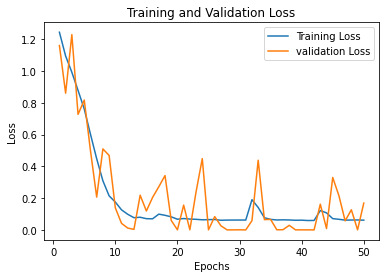

In [31]:
plt_acc_loss(loss_stats['train'], loss_stats['validation'], NUM_EPOCHS, 'Loss')

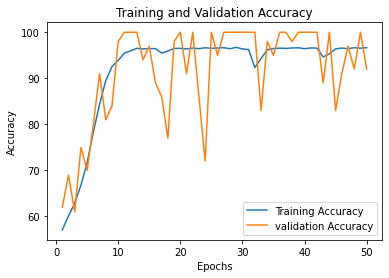

In [32]:
plt_acc_loss(accuracy_stats['train'], accuracy_stats['validation'], NUM_EPOCHS, 'Accuracy')

#### Testing the RNN Model

##### testing

In [63]:
def test_model(batch_size):
    k, test_loader = torchtext.legacy.data.BucketIterator.splits(
        (train_data, test_data),
         batch_size=batch_size,
         sort_within_batch=True,
         shuffle=True,
         sort_key=lambda x: len(x.TEXT),
         device=DEVICE)
    y_pred_list = []
    y_true_list = []

    model.eval()
    with torch.no_grad():
        for X_test_torch, y_test_torch in test_loader:
            X_test_t, y_test_t = X_test_torch.to(DEVICE), y_test_torch.to(DEVICE)

            y_torch_pred = model(X_test_t)
            _, y_t_pred = torch.max(y_torch_pred, dim=-1)

            y_pred_list.append(y_t_pred.cpu().numpy())
            y_true_list.append(y_test_t.cpu().numpy())

    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]

    return y_true_list, y_pred_list

In [64]:
batch_size_vals = []
y_pred_list = []
y_true_list = []
for i in range(1, 129):
    y_true_list, y_pred_list = test_model(i)
    batch_size_vals.append(accuracy_score(y_true_list, y_pred_list))

In [74]:
y_pred_list = []
y_true_list = []
y_true_list, y_pred_list = test_model(batch_size_vals.index(max(batch_size_vals)) + 1)

### **Classification Report**

In [75]:
print('____________________ /LSTM\ _____________________\n')
print('CLASSIFICATION REPORTS\n')
print(classification_report(y_true_list, y_pred_list, zero_division=0))
print('\nCONFUSION MATRIX\n')
print(confusion_matrix(y_true_list, y_pred_list))
print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_true_list, y_pred_list) :.3f}')

____________________ /LSTM\ _____________________

CLASSIFICATION REPORTS

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.33      0.50         3
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         2
           4       0.67      1.00      0.80         2

    accuracy                           0.87        23
   macro avg       0.91      0.80      0.81        23
weighted avg       0.90      0.87      0.85        23


CONFUSION MATRIX

[[13  0  0  0  0]
 [ 2  1  0  0  0]
 [ 0  0  2  0  1]
 [ 0  0  0  2  0]
 [ 0  0  0  0  2]]

MEAN SQUARE ERROR: 0.261


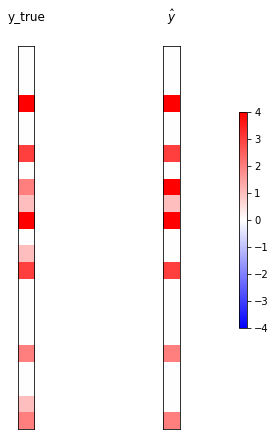

In [76]:
tensor_dict = {
    'y_true': torch.FloatTensor(y_true_list),
    '$\hat{y}$': torch.FloatTensor(y_pred_list)
    }

n = len(tensor_dict)
vmax = max(v.abs().max() for v in tensor_dict.values())
figsize = (2 * n, 6)
fig, axes = plt.subplots(1, n, figsize=figsize, constrained_layout=True, squeeze=True)
axes = axes.flat if isinstance(axes, np.ndarray) else (axes,)
for (name, v), ax in zip(tensor_dict.items(), axes):
    v = torch.squeeze(v.detach())
    if v.ndim == 1:
        v = v.view(-1, 1)
    img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap('bwr'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)
fig.colorbar(img, cax=fig.add_axes([0.985, 0.25, 0.03, .5]))